In [1]:
import numpy as np
import pandas as pd
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from skimage.filters import threshold_otsu
import scipy.ndimage as ndi

from tqdm.notebook import tqdm
from pycocotools import mask as maskUtils
from joblib import Parallel, delayed
import json,itertools

Inspired by
[Adriano Passos ](https://www.kaggle.com/coldfir3/efficient-coco-dataset-generator?scriptVersionId=79100851)



The comp encoding is rowise and every odd index represent the absolute
begining of the mask. In the other hand, coco format expects it to be
encoded by columns and the odd indexes are relative to the last end of the mask.

    1. Decode rle (competition) to binary mask
    2 .Encode the binary mask to rle (coco) using pycocotools
    3.Optional (Clean broken masks)
    4 .Save to .json

<h1><center>General Configurations</center></h1>

In [2]:
data_dir = './sartorius-cell-instance-segmentation'

TRAIN_CSV = f"{data_dir}/train.csv"
TRAIN_PATH = f"{data_dir}/train"
TEST_PATH = f"{data_dir}/test"
# annFile_path = f"{data_dir}/annotations_train.json"

ROOT = Path(data_dir)
#TRAIN_FILES = Path(TRAIN_PATH)

WIDTH = 704
HEIGHT = 520

# Normalize to resnet mean and std if True.
# RESNET_MEAN = [0.485, 0.456, 0.406]
# RESNET_STD = [0.229, 0.224, 0.225]
IMAGE_RESIZE = (224, 224)
TH = 40

In [3]:
df = pd.read_csv(TRAIN_CSV)

In [4]:
def clean_mask(mask):
    '''
    Function is called to identify whether the mask is broken
    returns True or False state and also returns a mask
    '''
    mask = mask > threshold_otsu(np.array(mask).astype(np.uint8))
    mask = ndi.binary_fill_holes(mask).astype(np.uint8)
    
    # New code for mask acceptance
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    c = contours[0][:, 0]
    diff = c - np.roll(c, 1, 0)
    # find horizontal lines longer than threshold
    targets = (diff[:, 1] == 0) & (np.abs(diff[:, 0]) >= TH)  
    
    return mask, (True in targets)

In [5]:
def rle2mask(rle, img_w, img_h):

    '''Function decodes rle (for sartorius comp) to
    binary mask'''

    array = np.fromiter(rle.split(), dtype=np.uint)
    array = array.reshape((-1, 2)).T
    array[0] = array[0] - 1

    ## decompressing the rle encoding (ie, turning [3, 1, 10, 2] into [3, 4, 10, 11, 12])
    # for faster mask construction

    starts, lenghts = array
    mask_decompressed = np.concatenate([np.arange(s, s + l, dtype=np.uint) for s, l in zip(starts, lenghts)])
    ## Building the binary mask
    msk_img = np.zeros(img_w * img_h, dtype=np.uint8)
    msk_img[mask_decompressed] = 1
    msk_img = msk_img.reshape((img_h, img_w))
    msk_img, broken_mask = clean_mask(msk_img)
    if broken_mask:
        broken_zero = np.zeros_like(msk_img)
        return np.asfortranarray(broken_zero)
    msk_img = np.asfortranarray(msk_img)  ## This is important so pycocotools can handle this object

    return msk_img

189036 1 189739 3 190441 6 191144 7 191848 8 192552 9 193256 10 193960 11 194664 11 195368 12 196072 12 196776 13 197480 13 198185 13 198889 13 199593 14 200297 13 201002 11 201706 10 202410 9 203115 7 203819 6 204523 5 205227 5 205932 3 206636 2 207340 1


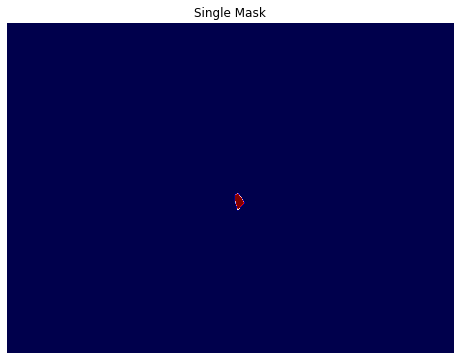

In [6]:
plt.figure(figsize=(8,8))
rle = df.loc[1, 'annotation']
print(rle)
plt.imshow(rle2mask(rle, WIDTH, HEIGHT),cmap='seismic')
plt.axis('off')
plt.title('Single Mask')
plt.show();

In [7]:
def build_mask(labels, input_shape, colors=False):
    height, width = input_shape
    masks = np.zeros((width,height))
    #masks = np.zeros((height,width), dtype=np.uint8)
    for i, label in enumerate(labels):
        a_mask = rle2mask(label, height,width)
        a_mask = np.array(a_mask) > 0 
# #         a_mask, broken_mask = clean_mask(a_mask)
# #         if broken_mask:
# #             continue
        masks += a_mask
#     masks = masks.clip(0,1)
    return masks

In [8]:
df_tr = df[df['id']=='0140b3c8f445'].reset_index(drop=True)

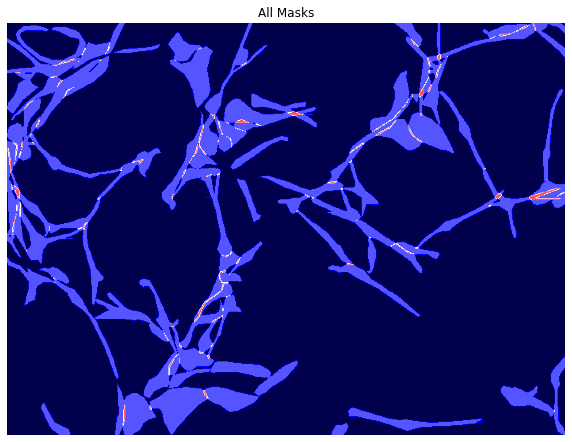

In [9]:
sample_masks1 = build_mask(df_tr['annotation'],(WIDTH, HEIGHT))

plt.figure(figsize=(10,10))
plt.imshow(sample_masks1, cmap='seismic')
plt.axis('off')
plt.title('All Masks')
plt.show();

In [10]:
def annotate(idx,row,cat_ids):
    '''
    Function is called to build json file
    '''
    
    # Binary mask
    mask = rle2mask(row['annotation'], row['width'], row['height']) 
    # Encoding it back to rle (coco format)
    c_rle = maskUtils.encode(mask) 
    # converting from binary to utf-8
    c_rle['counts'] = c_rle['counts'].decode('utf-8') 
    # calculating the area
    area = maskUtils.area(c_rle).item()
    # calculating the bboxes
    bbox = maskUtils.toBbox(c_rle).astype(int).tolist() 
    annotation = {
            'segmentation': c_rle,
            'bbox': bbox,
            'area': area,
            'image_id':row['id'], 
            'category_id':cat_ids[row['cell_type']], 
            'iscrowd':0, 
            'id':idx
        }
    return annotation

In [12]:
def coco_structure(df, workers = 4):
    
    ## Building the header
    cat_ids = {name:id+1 for id, name in enumerate(df.cell_type.unique())}    
    cats =[{'name':name, 'id':id} for name,id in cat_ids.items()]
    images = [{'id':id, 'width':row.width, 'height':row.height, 'file_name':f'train/{id}.png'} for id,row in df.groupby('id').agg('first').iterrows()]
    
    ## Building the annotations
    annotations = Parallel(n_jobs=workers)(delayed(annotate)(idx, row, cat_ids) for idx, row in tqdm(df.iterrows(), total = len(df)))
        
    return {'categories':cats, 'images':images, 'annotations':annotations}

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
train_files = sorted(list(Path(TRAIN_PATH).rglob('*png')))
test_files = sorted(list(Path(TEST_PATH).rglob('*.png')))
print(f'Number of pictures in train dir: {len(train_files)} pcs')
print()
print(f'Number of pictures in test dir: {len(test_files)} pcs')

Number of pictures in train dir: 606 pcs

Number of pictures in test dir: 3 pcs


In [18]:
# Split dataset to train and val sets
train_pics, val_pics = train_test_split(train_files, test_size=0.15, shuffle=True)

In [19]:
# Extract pic Id from Path
train_pic_id = [path.stem for path in train_pics]
val_pic_id = [path.stem for path in val_pics]
# Print number of files in tran and val sets
print(f'Number of pictures in train set: {len(train_pics)}')
print()
print(f'Number of pictures in val set: {len(val_pics)}')

Number of pictures in train set: 515

Number of pictures in val set: 91


In [20]:
# split pandas dataframe with annotations for train df and val df
# in consistance with given file Ids
df_train = df[(df['id'].isin(train_pic_id))]
df_val = df[(df['id'].isin(val_pic_id))]

print(f"Number of picture's id in train set {df_train.id.nunique()}")
print()
print(f"Number of picture's id in val set {df_val.id.nunique()}")

Number of picture's id in train set 515

Number of picture's id in val set 91


In [21]:
root = coco_structure(df)
train_root = coco_structure(df_train)
val_root = coco_structure(df_val)

  0%|          | 0/73585 [00:00<?, ?it/s]

  0%|          | 0/63528 [00:00<?, ?it/s]

  0%|          | 0/10057 [00:00<?, ?it/s]

In [24]:
pwd

'/home/paul/Projects/detectron'

In [25]:
with open('annotations_all.json', 'w', encoding='utf-8') as f:
    json.dump(root, f, ensure_ascii=True, indent=4)

In [26]:
with open('annotations_train.json', 'w', encoding='utf-8') as f:
    json.dump(train_root, f, ensure_ascii=True, indent=4)

In [27]:
with open('annotations_val.json', 'w', encoding='utf-8') as f:
    json.dump(val_root, f, ensure_ascii=True, indent=4)

In [28]:
valFile_path = f"{data_dir}/annotations_val.json"

In [30]:
#TRAIN_FILES = sorted(list(Path(TRAIN_PATH).rglob('*png')))
annFile = Path(valFile_path)
coco = COCO(annFile)
imgIds = coco.getImgIds()

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


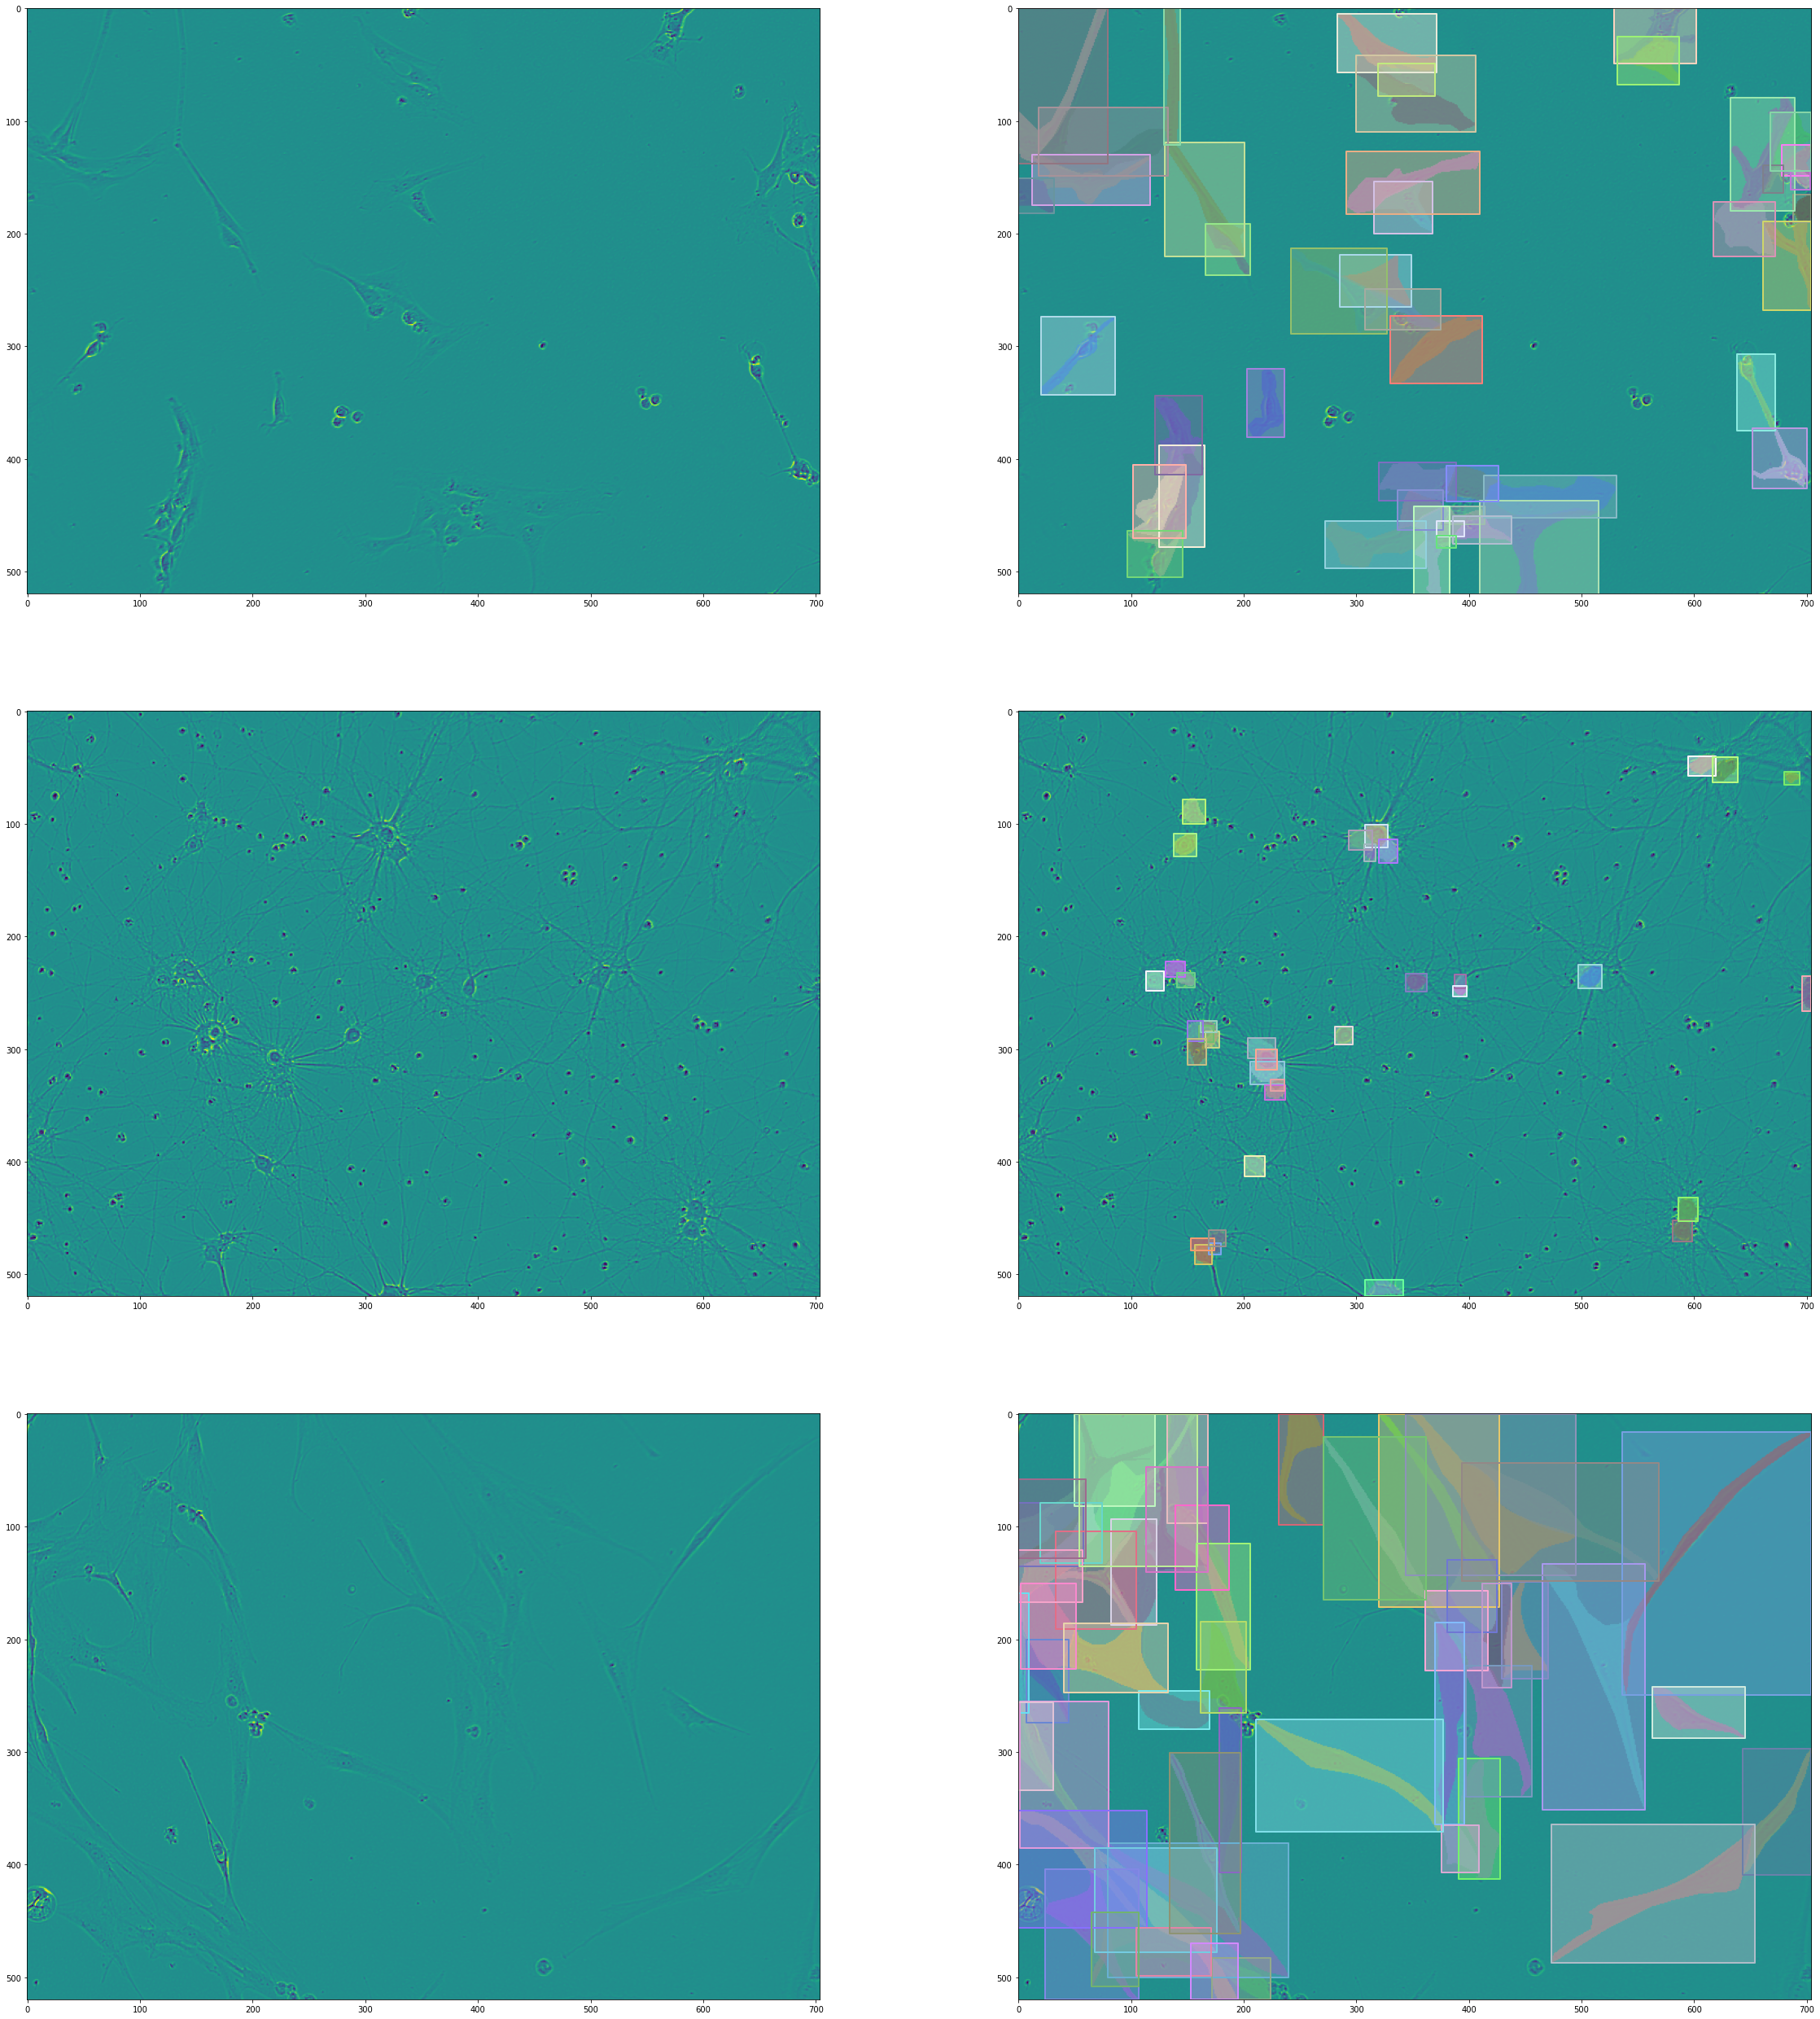

In [31]:
imgs = coco.loadImgs(imgIds[-3:])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = io.imread(ROOT/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)